In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.special import softmax
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split



### Homework: Revisiting how to find optimized clustes

As the dimensionality of the data increases so do the distances and the sparsity. In such cases, `shiluatte_score()` can fail to help finding the optimal number of clusters. In this task you will compare shiluette score with adjusted randomized index, another score, for a high dimensional data set related to some cancer disease.

1. Load the data by using the code below.
2. Check the data content, and encode the labels to numerical values with `LabelEncoder()`. Set the `n_clusters` to the number of unique labels. (1 point)
3. Preprocess the data by scaling it with MinMaxScaler and then applying PCA with `n_components=2`. (2 points)
4. Cluster the preprocessed data using KMeans. (1 point)
5. Evaluate clustering performance with Silhouette Score and Adjusted Rand Index (ARI). (1 point)
6. Visualize the clustering results. With your visualization encode the predicted label with colors and the true labels with markers. (2 points)
7. Study how clustering performance varies with different numbers of PCA components. (3 points)

If you did everything correctly, then you should see the shiluette score monotonically decreasing, hence it does not predict optimal cluster number, but the ARI has a maximum at `n=7`, thus it indicates the optimal partitioning number.

In [3]:
import tarfile
import urllib
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()
   
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
        datafile,
        delimiter=",",
        usecols=range(1, 20532),
        skip_header=1
    )
   
true_label_names = np.genfromtxt(
     labels_file,
     delimiter=",",
     usecols=(1,),
     skip_header=1,
     dtype="str"
 )

C:\Users\mozer\AppData\Local\Temp\ipykernel_15440\235291657.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


2

In [5]:
unique_label_names = np.unique(true_label_names)
n_clusters = unique_label_names.shape[0]
le = preprocessing.LabelEncoder()
le.fit(unique_label_names)
numerical_labels = le.transform(true_label_names)

3

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scaled_data)
pca_transformed_data = pca.transform(scaled_data)
pca_transformed_data_inv = pca.inverse_transform(pca_transformed_data)

In [54]:
pca_transformed_data_inv.shape, pca_transformed_data.shape

((801, 20531), (801, 2))

4

In [1]:
kmeans = KMeans(n_clusters = n_clusters, random_state = 0, n_init='auto')
kmeans.fit(pca_transformed_data_inv)

NameError: name 'KMeans' is not defined

In [42]:
silhouette_score(pca_transformed_data_inv, kmeans.labels_, metric='euclidean')

0.5141316407754857

In [43]:
silhouette_score(scaled_data, kmeans.labels_, metric='euclidean')

0.15107159695235128

ARI

In [52]:
from sklearn import metrics
metrics.adjusted_rand_score(numerical_labels, kmeans.labels_)

0.7240677247432811

<Axes: >

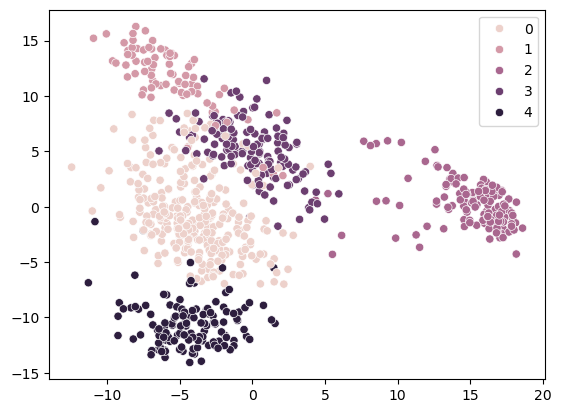

In [61]:
sns.scatterplot(x = pca_transformed_data[:,0], y = pca_transformed_data[:,1], hue = numerical_labels)

<Axes: >

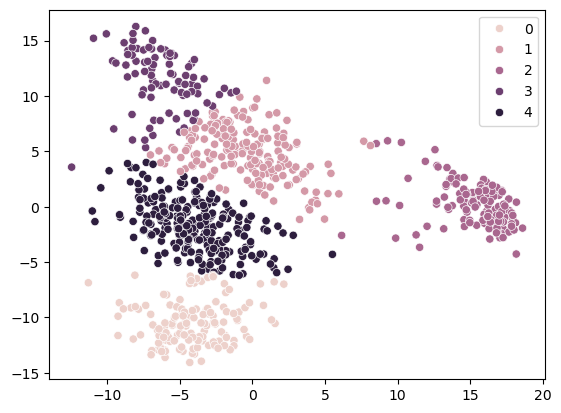

In [62]:
sns.scatterplot(x = pca_transformed_data[:,0], y = pca_transformed_data[:,1], hue = kmeans.labels_)

At firs glance, the one using the kmeans.labels_ looks like a better clustering but that is because we used the pca transformed data to fit the kmeans and then we plot using the pca transformed data

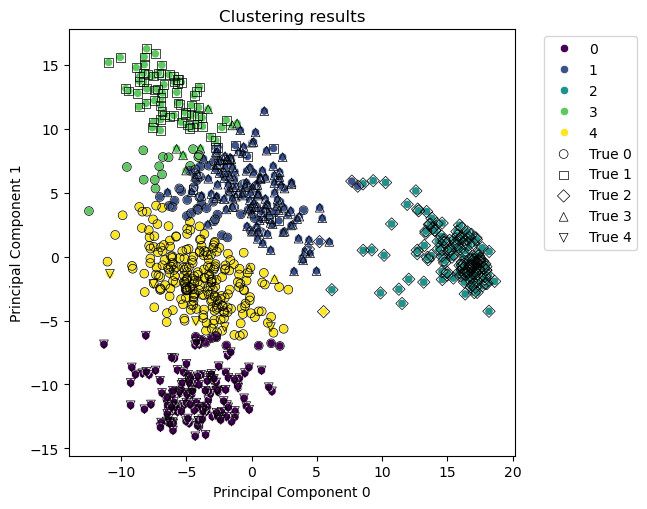

In [68]:
ax = sns.scatterplot(x=pca_transformed_data[:,0], 
                     y=pca_transformed_data[:,1], 
                     hue=kmeans.labels_,
                     palette='viridis',  
                     legend='full')

unique_markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X']  
for i, true_label in enumerate(np.unique(numerical_labels)):
    mask = numerical_labels == true_label
    ax.scatter(pca_transformed_data[mask, 0], 
               pca_transformed_data[mask, 1], 
               marker=unique_markers[i],
               label=f'True {true_label}',
               facecolors='none', 
               edgecolors='black',  
               linewidths=0.5,
               s=40)  

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 1")
plt.title("Clustering results")
plt.show()

7

In [75]:
n_components = [2,3,4,5,6,7,8,9,10]
# n_components = [2,7,9]

aris = np.zeros(len(n_components))
silhouette_score_pca_transformed_data_inv = np.zeros(len(n_components))
silhouette_score_pca_scaled_data = np.zeros(len(n_components))

for idx, n in enumerate(n_components):
    pca = PCA(n_components=n)
    pca.fit(scaled_data)
    pca_transformed_data = pca.transform(scaled_data)
    pca_transformed_data_inv = pca.inverse_transform(pca_transformed_data)
    kmeans = KMeans(n_clusters = n_clusters, random_state = 0, n_init='auto')
    kmeans.fit(pca_transformed_data_inv)
    

    aris[idx] = metrics.adjusted_rand_score(numerical_labels, kmeans.labels_)
    silhouette_score_pca_transformed_data_inv[idx] = silhouette_score(pca_transformed_data_inv, kmeans.labels_, metric='euclidean')
    silhouette_score_pca_scaled_data[idx] = silhouette_score(scaled_data, kmeans.labels_, metric='euclidean')

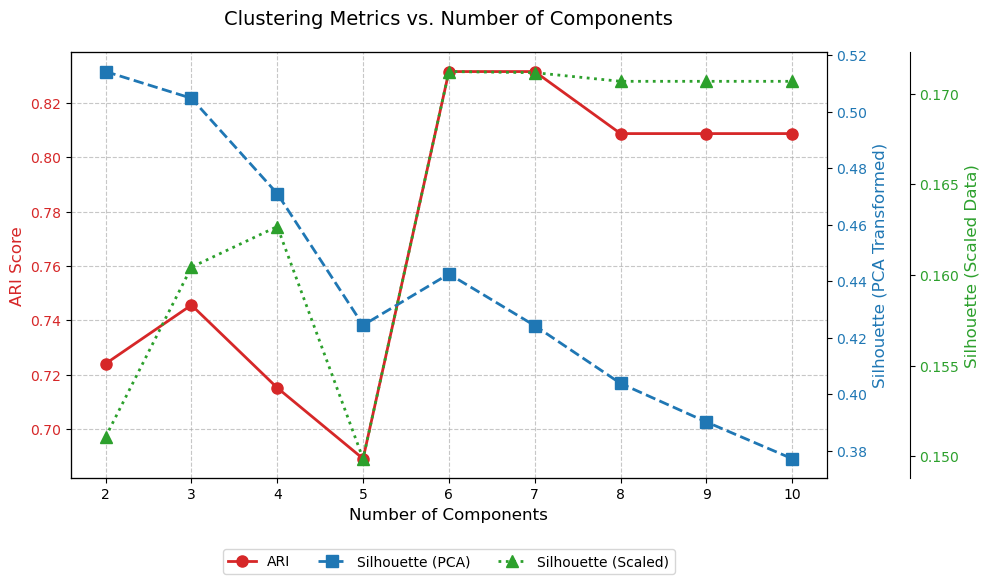

In [76]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Number of Components', fontsize=12)
ax1.set_ylabel('ARI Score', color=color, fontsize=12)
ax1.plot(n_components, aris, color=color, marker='o', linestyle='-', linewidth=2, markersize=8, label='ARI')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette (PCA Transformed)', color=color, fontsize=12)
ax2.plot(n_components, silhouette_score_pca_transformed_data_inv, color=color, marker='s', linestyle='--', linewidth=2, markersize=8, label='Silhouette (PCA)')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  
ax3.set_ylabel('Silhouette (Scaled Data)', color=color, fontsize=12)
ax3.plot(n_components, silhouette_score_pca_scaled_data, color=color, marker='^', linestyle=':', linewidth=2, markersize=8, label='Silhouette (Scaled)')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Clustering Metrics vs. Number of Components', fontsize=14, pad=20)
ax1.grid(True, linestyle='--', alpha=0.7)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.show()

The results from the analysis confirm the trends mentioned in the assignment description.

The Adjusted Rand Index (ARI) score peaks when the number of principal components is 7. Since ARI measures the similarity between the predicted labels and the true labels, this peak indicates that 7 is the optimal number of components for recovering the ground-truth clusters.

In contrast, the silhouette score calculated on the PCA-transformed data decreases as more components are added. The silhouette score evaluates the geometric separation of clusters, and in higher dimensions, this separation can become less distinct, leading to a lower score. This metric does not use the true labels, so it evaluates the clustering structure independently of the ground truth.

Ultimately, both the ARI and the silhouette score calculated on the original scaled data suggest that the ideal number of principal components for this clustering task is around 6 or 7.